# RNN

In [126]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Gerando dados

In [127]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        #grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        #convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #create the y data for the time series x axis from previous step
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        #create the Y data for the time series x axis from step
        y_batch = np.sin(batch_ts)
        
        #Formating for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)
     

In [128]:
ts_data = TimeSeriesData(250, 0, 10)

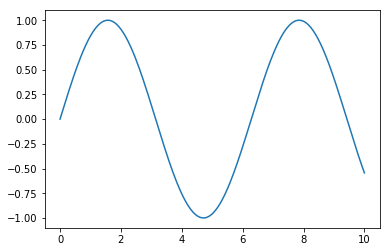

In [129]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [130]:
num_time_steps = 30

In [131]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

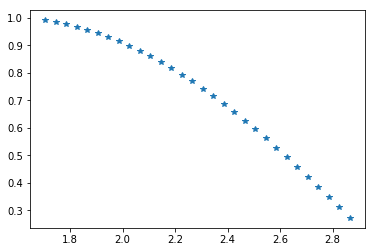

In [132]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

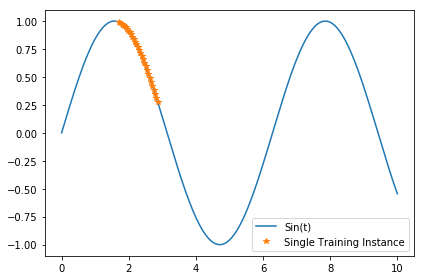

In [133]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label="Single Training Instance")
plt.legend()
plt.tight_layout()

### Dados de Treino

In [134]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

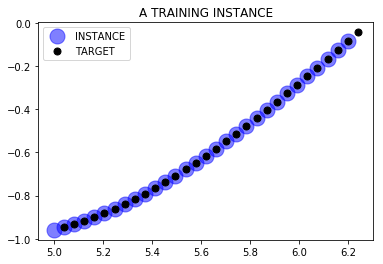

In [135]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label="INSTANCE")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')
plt.legend()

## Gerando Modelo

In [136]:
tf.reset_default_graph()

In [137]:
num_inputs = 1

In [138]:
num_neurons = 100

In [139]:
num_outputs = 1

In [140]:
learning_rate = 0.0001

In [141]:
num_train_iterations = 2000

In [142]:
batch_size = 1

### Placeholders

In [143]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [144]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

### RNN Cell

In [145]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

In [146]:
outputs, states = tf.nn.dynamic_rnn(cell, X,dtype=tf.float32)

### Minimum Squared Error

In [147]:
loss = tf.reduce_mean(tf.square(outputs-y))

### Optimizer

In [148]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [149]:
train = optimizer.minimize(loss)

In [150]:
init = tf.global_variables_initializer()

##### Opçoes de GPU

In [151]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)

##### Saver

In [152]:
saver = tf.train.Saver()

### Session

In [153]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration,'\tMSE', mse)
            
    saver.save(sess,"./rnn_time_series_model_codealong")

0 	MSE 0.662659
100 	MSE 0.0798865
200 	MSE 0.166035
300 	MSE 0.0116437
400 	MSE 0.0197412
500 	MSE 0.00373547
600 	MSE 0.0204063
700 	MSE 0.0196919
800 	MSE 0.00027515
900 	MSE 0.013043
1000 	MSE 0.00305908
1100 	MSE 0.0118424
1200 	MSE 0.0104036
1300 	MSE 0.00297956
1400 	MSE 0.000517349
1500 	MSE 0.0049364
1600 	MSE 0.00463692
1700 	MSE 0.00910338
1800 	MSE 0.00394163
1900 	MSE 0.00237397


In [154]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_series_model_codealong")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


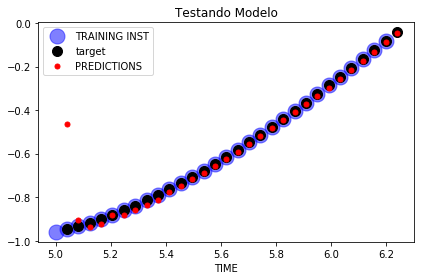

In [155]:
plt.title("Testando Modelo")

plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label='TRAINING INST')

plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label='target')

plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='PREDICTIONS')

plt.xlabel('TIME')
plt.legend()
plt.tight_layout()

# Gerando Nova Sequencia

In [156]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


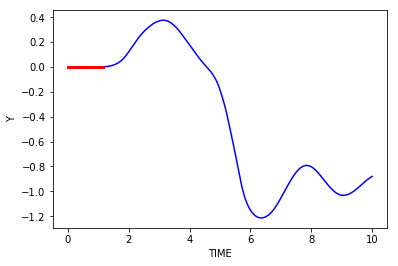

In [157]:
plt.plot(ts_data.x_data,zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')

In [158]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


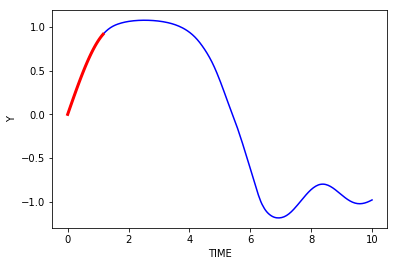

In [159]:
plt.plot(ts_data.x_data,training_instance, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')